In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import cv2
from os import listdir
# from sklearn.metrics import accuracy_score
from PIL import Image

import tensorflow as tf
# import tensorflow_hub as hub  #pip install tensorflow_hub
import os
#import tokenization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
#from tokenization import FullTokenizer
# from keras import backend as K
# sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

# from keras_lr_finder import LRFinder
# from pprint import pprint
# tf.logging.set_verbosity(tf.logging.ERROR)
from random import choice
import gc
#from bert import tokenization

no_of_gpu = 1

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.set_random_seed(42)

import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

/Users/huangdaolang/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/huangdaolang/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/huangdaolang/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/huangdaolang/.local/lib/python3.7/site-packages/tensorflow/pyth

In [ ]:
# Params for bert model and tokenization
#bert_path = "https://tfhub.dev/google/bert_chinese_L-12_H-768_A-12/1"
bert_path = "bert_chinese/"

In [2]:
df = pd.read_csv("../data/train.csv")
df = df.drop_duplicates(
    subset=['text', 'piclist', 'userGender', 'userFollowCount', 'userFansCount', 'userWeiboCount', 'userLocation',
            'userDescription']).reset_index()
data_size = len(df)

df['label'].value_counts()

0    17042
1    17010
Name: label, dtype: int64

In [3]:
# category statistic
category = list(set(df['category']))

category_statistic = {'科技':0, '社会生活':0, '文体娱乐':0, '教育考试':0, '军事':0, '医药健康':0, '政治':0, '财经商业':0}

for i in df['category']:
    category_statistic[i] += 1

category_statistic

{'科技': 283,
 '社会生活': 20740,
 '文体娱乐': 2633,
 '教育考试': 905,
 '军事': 400,
 '医药健康': 6368,
 '政治': 1259,
 '财经商业': 1464}

([<matplotlib.axis.XTick at 0x7fa6ab75ebd0>,
 <a list of 2 Text xticklabel objects>)

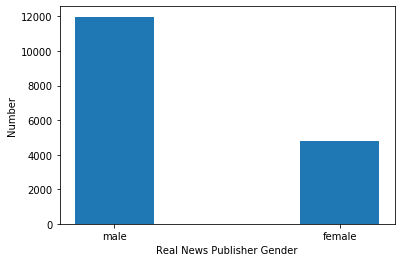

In [4]:
# Gender Statistic

num_male = 0
num_female = 0
for i in range(len(df)):
    if df['userGender'][i] == '男' and df['label'][i] == 0:
        num_male += 1
    if df['userGender'][i] == '女' and df['label'][i] == 0:
        num_female += 1
x = (num_male,num_female)
plt.bar(np.arange(2),x, width=0.35)
plt.xlabel('Real News Publisher Gender')
plt.ylabel('Number')
plt.xticks(np.arange(2),('male','female'))

In [5]:
# Location Credibility Statistic
c = 'userLocation'
tmp = df.groupby(c).agg({'label':['mean','size']})
tmp.columns = ['credibility','count']
tmp.reset_index()
tmp.sort_values(by=['count'],inplace=True,ascending=False)
tmp.head(10)

,credibility,count
userLocation,,
北京,0.347222,2160
其他,0.596929,2084
广东,0.618812,808
广东 广州,1.000000,597
上海,0.547945,584
北京东城区,0.000000,528
广东广州,0.000000,508
北京海淀区,0.000000,444
四川成都,0.000000,442


21417


(array([5329., 4361., 3339., 1345., 1147.,  620.,  305.,  168.,  113.,
         111.,   70.]),
 array([   0,  200,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
        5000]),
 <a list of 11 Patch objects>)

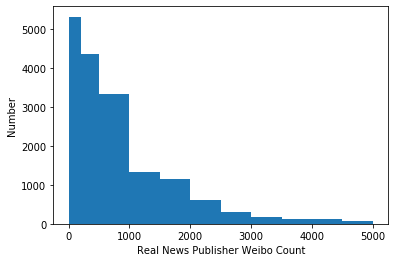

In [6]:
# User Fans and Follower Statistic
df['userFollowCount'] = df['userFollowCount'].fillna(0)
maximum = 0
for i in df['userFollowCount']:
    if int(i) > maximum:
        maximum = int(i)
print(maximum)
plt.xlabel('Real News Publisher Weibo Count')
plt.ylabel('Number')
plt.hist([int(df['userFollowCount'][s]) for s in range(len(df['userFollowCount'])) if df['label'][s] == 0],
         bins=[0,200,500,1000,1500,2000,2500,3000,3500,4000,4500,5000])



In [7]:
# News Attribute Generator
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import OneHotEncoder 

data = df
data['userLocation'] = data['userLocation'].fillna('没有地址')
data['userGender'] = data['userGender'].fillna('nan')
data['category'] = data['category'].fillna('没有分类')

userLocation = np.array(data['userLocation'])
userGender = np.array(data['userGender'])
category = np.array(data['category'])

userLocation = LabelEncoder().fit_transform(userLocation)
userGender = LabelEncoder().fit_transform(userGender)
category = LabelEncoder().fit_transform(category)

userLocation = OneHotEncoder(sparse=False).fit_transform(userLocation.reshape((-1,1)))
userGender = OneHotEncoder(sparse=False).fit_transform(userGender.reshape((-1,1)))
category = OneHotEncoder(sparse=False).fit_transform(category.reshape((-1,1)))
# userLocation = to_categorical(userLocation)
# userDescription = to_categorical(userDescription)
# category = to_categorical(category)

len(userLocation), len(userGender), len(category)

(34052, 34052, 34052)

In [8]:
# a 956-d list which stores the attribute
attribute = []
for i in range(len(category)):
    attribute.append(userGender[i].tolist() + category[i].tolist() + userLocation[i].tolist())

In [9]:
data['userDescription'] = data['userDescription'].fillna('没有描述')
data['piclist'] = data['piclist'].fillna('')
data['userDescription'].head()

0    我们虚度的今天恰是。。昨天去世人渴望的明天。
1                      用心生活
2                      没有描述
3              中国青年报•中青在线微博
4             能烧得全烧了，只剩下石头。
Name: userDescription, dtype: object

ff59503827f3d9f6c0b0723e5d39cb39.jpg	cd1b58b49a515039ea387ef34b282f4c.jpg	4c67880f93a4424a3f5d50dddec54d12.jpg	97e39a9a0559dba56144a4351c11c512.jpg	b1745194178ec6749eb828dba0b039d4.jpg


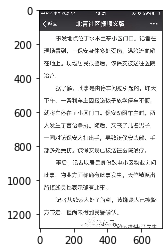

In [11]:
list_images_dir = listdir('../data/images/')
print(data['piclist'][9])

for i in data['piclist'][9].split("	"):
    plt.imshow(Image.open("../data/images/" + str(i)))

In [12]:
count = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0}
for i in data['piclist']:
    count[str(len(i.split("\t")))] +=1
    

In [13]:
count

{'0': 0,
 '1': 29729,
 '2': 1288,
 '3': 805,
 '4': 600,
 '5': 208,
 '6': 391,
 '7': 99,
 '8': 96,
 '9': 836}

In [18]:
29729-14455

15274

In [17]:
def index_to_delete(list_):
    list_images_dir = listdir('../data/images/')
    index = []
    for i,v in enumerate(list_):
        image_list = v.split('	')
        if str(v) == '':
            index.append(i)
        for j in range(len(image_list)):
            if image_list[j] not in list_images_dir:
                index.append(i)
        if ".gif" in v:
            index.append(i)
    return list(set(index))

data_delete_index = index_to_delete(data['piclist'])
len(data_delete_index)

14455

In [12]:
data_image = np.array(data['piclist'])
data_text = np.array(data['text'])
data_label = np.array(data['label'])
data_description = np.array(data['userDescription'])
data_attribute = np.array(attribute)

data_image = np.delete(data_image, data_delete_index)
data_text = np.delete(data_text, data_delete_index)
data_label = np.delete(data_label, data_delete_index)
data_description = np.delete(data_description, data_delete_index)
data_attribute = np.delete(data_attribute, data_delete_index, axis=0)

shuffle_index= np.arange(len(data_image))
np.random.shuffle(shuffle_index)
data_image = data_image[shuffle_index]
data_text = data_text[shuffle_index]
data_label = data_label[shuffle_index]
data_description = data_description[shuffle_index]
data_attribute = data_attribute[shuffle_index]

In [13]:
for i in range(len(data_image)):
    image_list = data_image[i].split('	')
    data_image[i] = image_list

In [14]:
len(data_image),len(data_text),len(data_label),len(data_attribute), len(data_description)

(19195, 19195, 19195, 19195, 19195)

In [15]:
np.save('data/data_image.npy', data_image)
np.save('data/data_text.npy', data_text)
np.save('data/data_label.npy', data_label)
np.save('data/data_description.npy', data_description)
np.save('data/data_attribute.npy', data_attribute)

In [16]:
data_image = np.load('data/data_image.npy',allow_pickle=True)
data_text = np.load('data/data_text.npy',allow_pickle=True)
data_label = np.load('data/data_label.npy',allow_pickle=True)
data_description = np.load('data/data_description.npy',allow_pickle=True)
data_attribute = np.load('data/data_attribute.npy',allow_pickle=True)

In [17]:
length = int(len(data_image) * 0.8)
train_images = data_image[:length]
train_text = data_text[:length]
train_description = data_description[:length]
train_attribute = data_attribute[:length]
trainY = data_label[:length]
test_images = data_image[length:]
test_text = data_text[length:]
test_description = data_description[length:]
test_attribute = data_attribute[length:]
testY = data_label[length:]

np.save('data/train_text.npy',train_text)
np.save('data/train_description.npy',train_description)
np.save('data/train_label.npy',trainY)
np.save('data/train_attribute.npy',train_attribute)
np.save('data/test_text.npy',test_text)
np.save('data/test_description.npy',test_description)
np.save('data/test_label.npy',testY)
np.save('data/test_attribute.npy',test_attribute)

In [18]:
len(train_images),len(test_images), len(trainY), len(testY)

(15356, 3839, 15356, 3839)

In [19]:
# calculate the maximum document length
def max_length(texts):
    return [len(i) for i in texts]

max len {max_length(train_text)}


(array([2228., 2944., 8290., 1125.,  310.,  148.,   68.,   53.,   36.,
          15.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 498]),
 <a list of 10 Patch objects>)

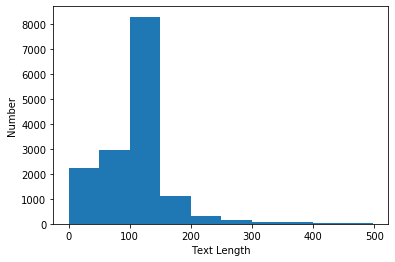

In [20]:
print('max len {max_length(train_text)}')
plt.xlabel('Text Length')
plt.ylabel('Number')
plt.hist([len(s) for s in train_text],bins=[0,50,100,150,200,250,300,350,400,450,498])

In [21]:
max_seq_length = 512

# Text part

In [ ]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, trainY 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, testY
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

# Image Part

In [22]:
length = 224
width = 224
channels = 3

In [23]:
error = []
def read_and_process_image(list_of_images):
    X = [] 
    for images in tqdm_notebook(list_of_images):
        b = []
        for image in images:
            a = cv2.imread(image, cv2.IMREAD_COLOR)
            try:
                b.append(cv2.resize(a, (length,width), interpolation=cv2.INTER_CUBIC))  
            except:
                print(a)
                error.append(image)
        X.append(b)
    return X

In [24]:
for i in range(len(train_images)):
    for j in range(len(train_images[i])):
        train_images[i][j] = 'data/images/' + train_images[i][j]

for i in range(len(test_images)):
    for j in range(len(test_images[i])):
        test_images[i][j] = 'data/images/' + test_images[i][j]

In [25]:
train_images[1]

['data/images/8ac7344ba8a8335fd8c0dca2ae5c2dc4.jpg']

In [26]:
train_imagesX = read_and_process_image(train_images)
test_imagesX = read_and_process_image(test_images)

In [27]:
error

[]

In [29]:
np.save('data/train_imagesX.npy', train_imagesX)
np.save('data/test_imagesX.npy', test_imagesX)

In [34]:
train_imagesX = np.array(train_imagesX)

for i in range(len(train_imagesX)):
    train_imagesX[i] = np.array(train_imagesX[i])

In [40]:
for i in train_imagesX:
    if len(i) > 1:
        print(i.shape)

(4, 224, 224, 3)
(2, 224, 224, 3)
(9, 224, 224, 3)
(4, 224, 224, 3)
(4, 224, 224, 3)
(4, 224, 224, 3)
(3, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(9, 224, 224, 3)
(9, 224, 224, 3)
(2, 224, 224, 3)
(6, 224, 224, 3)
(2, 224, 224, 3)
(5, 224, 224, 3)
(4, 224, 224, 3)
(6, 224, 224, 3)
(9, 224, 224, 3)
(6, 224, 224, 3)
(3, 224, 224, 3)
(2, 224, 224, 3)
(4, 224, 224, 3)
(5, 224, 224, 3)
(6, 224, 224, 3)
(4, 224, 224, 3)
(2, 224, 224, 3)
(3, 224, 224, 3)
(4, 224, 224, 3)
(4, 224, 224, 3)
(4, 224, 224, 3)
(3, 224, 224, 3)
(3, 224, 224, 3)
(8, 224, 224, 3)
(2, 224, 224, 3)
(8, 224, 224, 3)
(6, 224, 224, 3)
(3, 224, 224, 3)
(4, 224, 224, 3)
(7, 224, 224, 3)
(3, 224, 224, 3)
(9, 224, 224, 3)
(9, 224, 224, 3)
(4, 224, 224, 3)
(6, 224, 224, 3)
(8, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(3, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(9, 224, 224, 3)
(3, 224, 224, 3)
(4, 224, 224, 3)
(2, 224, 224, 3)
(4, 224, 224, 3)
(6, 224, 224, 3)
(3, 224, 224, 

(3, 224, 224, 3)
(5, 224, 224, 3)
(4, 224, 224, 3)
(3, 224, 224, 3)
(9, 224, 224, 3)
(4, 224, 224, 3)
(6, 224, 224, 3)
(9, 224, 224, 3)
(4, 224, 224, 3)
(3, 224, 224, 3)
(9, 224, 224, 3)
(3, 224, 224, 3)
(9, 224, 224, 3)
(3, 224, 224, 3)
(2, 224, 224, 3)
(3, 224, 224, 3)
(9, 224, 224, 3)
(9, 224, 224, 3)
(6, 224, 224, 3)
(6, 224, 224, 3)
(8, 224, 224, 3)
(2, 224, 224, 3)
(8, 224, 224, 3)
(7, 224, 224, 3)
(4, 224, 224, 3)
(4, 224, 224, 3)
(2, 224, 224, 3)
(4, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(3, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(6, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(3, 224, 224, 3)
(3, 224, 224, 3)
(2, 224, 224, 3)
(9, 224, 224, 3)
(9, 224, 224, 3)
(4, 224, 224, 3)
(2, 224, 224, 3)
(4, 224, 224, 3)
(4, 224, 224, 3)
(2, 224, 224, 3)
(6, 224, 224, 3)
(3, 224, 224, 3)
(3, 224, 224, 3)
(2, 224, 224, 3)
(2, 224, 224, 3)
(9, 224, 224, 3)
(9, 224, 224, 3)
(4, 224, 224, 3)
(3, 224, 224, 3)
(5, 224, 224, 3)
(6, 224, 224, 3)
(6, 224, 224, 3)
(3, 224, 224, 

In [ ]:
train_imagesX = np.load('data/train_imagesX.npy')
test_imagesX = np.load('data/test_imagesX.npy')

In [ ]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )

        trainable_vars = self.bert.variables

        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]

        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [ ]:
def initialize_vars(sess):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) #command to run codeon multiple gpu
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [ ]:
def get_news_model(params):
    
    K.clear_session()
    
    with tf.device('/gpu:0'):
        bert_base = BertLayer()
        bert_base.trainable= params['bert_trainable']

        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]
        bert_output = bert_base(bert_inputs)

        if params['text_no_hidden_layer']>0:
            for i in range(params['text_no_hidden_layer']):
                bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
                bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

        text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

        #image model
        conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=True, input_shape=(224,224,3))
        conv_base.trainable=False

        input_image = tf.keras.layers.Input(shape=(224,224,3))
        base_output = conv_base(input_image)
        flat = tf.keras.layers.Flatten()(base_output)

        if params['vis_no_hidden_layer']>0:
            for i in range(params['vis_no_hidden_layer']):
                flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
                flat = tf.keras.layers.Dropout(params['dropout'])(flat)

        visual_repr = tf.keras.layers.Dense(params['repr_size'],activation='relu')(flat)


        #classifier
        combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
        com_drop=tf.keras.layers.Dropout(params['dropout'])(combine_repr)

        if params['final_no_hidden_layer']>0:
            for i in range(params['final_no_hidden_layer']):
                com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
                com_drop=tf.keras.layers.Dropout(params['dropout'])(com_drop)

        prediction = tf.keras.layers.Dense(1,activation='sigmoid')(com_drop)

        model = tf.keras.models.Model(inputs=[in_id,in_mask,in_segment,input_image], outputs=prediction)

    #model = tf.keras.utils.multi_gpu_model(model,gpus=no_of_gpu)
    
#     if params['optimizer'] == 'adam':
#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#     else:
#         opt = tf.keras.optimizers.RMSprop(lr=0.00005)
        
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    initialize_vars(sess)
    
    
    return model

In [ ]:
params_data = {
    'bert_trainable' :True,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':tf.keras.optimizers.Adam
}

In [ ]:
model=get_news_model(params_data)

In [ ]:
out = model.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.33)

In [ ]:
model.save('MMFFND-Spotfake-Finetune.h5')

In [ ]:
#model.load('MMFFND-Spotfake-Finetune.h5')

In [ ]:
test_predict = model.predict([test_input_ids, test_input_masks, test_segment_ids,test_imagesX])
test_predict = [1 if i>=0.5 else 0 for i in test_predict]

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [ ]:
print(f'Accuracy == {accuracy_score(testY,test_predict)}')
print(f'F1 == {f1_score(testY,test_predict,average=None)}')
print(f'Precision == {precision_score(testY,test_predict,average=None)}')
print(f'Recall == {recall_score(testY,test_predict,average=None)}')

In [ ]:
fault = []
for i in range(len(test_predict)):
    if test_predict[i] != testY[i]:
        fault.append(i)

In [ ]:
len(fault)

In [ ]:
testY[1]

In [ ]:
for i in fault:
    print(test_text[i] + "  predict: " + str(test_predict[i]) + ", truth: " + str(int(testY[i])) + "\n")

In [ ]:
params_data_2 = {
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':400,
    'dropout':0.3,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':64,
    'optimizer':tf.keras.optimizers.Adam
}

model_2=get_news_model(params_data_2)

In [ ]:
out_2 = model_2.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY))

In [ ]:
test_predict = model_2.predict([test_input_ids, test_input_masks, test_segment_ids,test_imagesX])
test_predict = [1 if i>=0.5 else 0 for i in test_predict]

print(f'Accuracy == {accuracy_score(testY,test_predict)}')
print(f'F1 == {f1_score(testY,test_predict,average=None)}')
print(f'Precision == {precision_score(testY,test_predict,average=None)}')
print(f'Recall == {recall_score(testY,test_predict,average=None)}')